# SIMN - Ka band correlation study

In [133]:
# Libraries
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ismn.interface import ISMN_Interface
from scipy import stats
# Custom
import sys
sys.path.append("../src")
from processing import load_zip, apply_scaling

# Global
%matplotlib inline

ka_path = "../data/raw/ka.zip"
ismn_path = "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"

In [2]:
# Load Ka zip and save the Brightness temperature
ka_dataset = load_zip(ka_path)
ka_dataset = apply_scaling(ka_dataset)

Loading zipfile from ../data/raw/ka.zip


  0%|          | 0/754 [00:00<?, ?it/s]

100%|██████████| 754/754 [00:21<00:00, 35.32it/s]


Applying scaling


100%|██████████| 3/3 [00:10<00:00,  3.55s/it]


In [5]:
# Load the ISMN data and select for the station,
ismn_data = ISMN_Interface(ismn_path)


Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [7]:
# Selection
network = "FMI"
station = "SOD130"
sensor = "CS655-B_soil_temperature_0.050000_0.050000"

In [13]:
# Get lat and lon coordinates
lon = ismn_data[network][station][sensor].metadata["longitude"][1]
lat = ismn_data[network][station][sensor].metadata["latitude"][1]

(26.74857, 67.25729)

Text(0.5, 1.0, 'Network: FMI, station: SOD130')

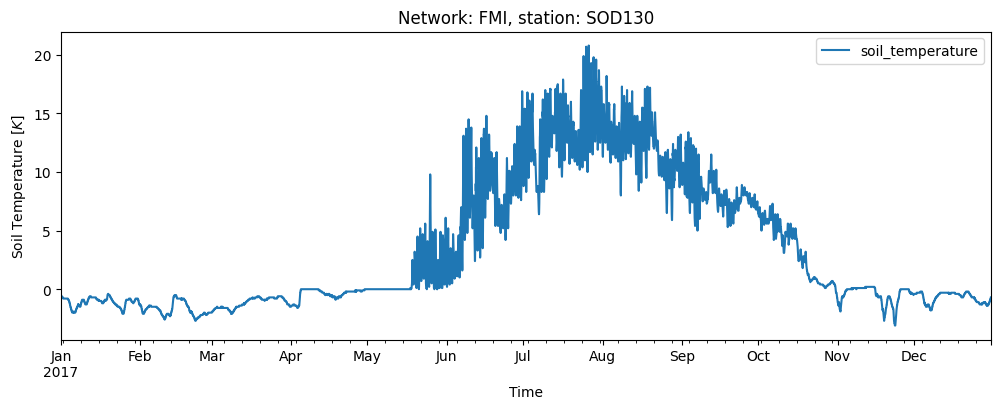

In [15]:
# Get the timeseries for the sensor
ismn_timeseries = ismn_data[network][station][sensor]

# Optional: plot
ax = ismn_timeseries.data.plot(figsize=(12,4))
ax.set_xlabel("Time")
ax.set_ylabel("Soil Temperature [$K$]")
plt.title (f"Network: {network}, station: {station}")

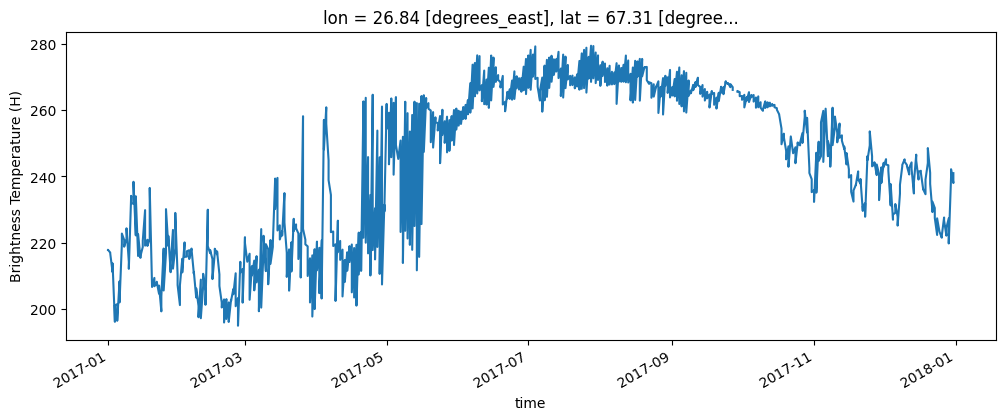

In [25]:
# Select the ka band for the coordinates
ka_timeseries = ka_dataset.sel({"lat" : lat, "lon" : lon}, method= "nearest")
ka_timeseries["Brightness Temperature (H)"].plot(figsize=(12,4))

In [21]:
ka_timeseries

<xarray.Dataset>
Dimensions:                     (time: 730)
Coordinates:
    lon                         float32 26.84
    lat                         float32 67.31
  * time                        (time) datetime64[ns] 2017-01-01 ... 2017-12-31
    Pass                        (time) <U10 'Ascending' ... 'Descending'
Data variables:
    Brightness Temperature (H)  (time) float32 217.8 217.8 217.0 ... 238.0 241.0
    Brightness Temperature (V)  (time) float32 230.8 230.6 229.6 ... 247.6 249.3
    Time Information            (time) float32 -145.0 -538.0 ... -601.0 68.0
Attributes: (12/28)
    CDI:                       Climate Data Interface version 1.9.9 (https://...
    Conventions:               CF-1.6
    ProductName:               AMSR2-L3
    GeophysicalName:           Brightness Temperature (36GHz)
    MeanType:                  DayMean
    Projection:                EQR
    ...                        ...
    OrbitDirection:            Ascending
    PlatformShortName:         GCOM-W1
    SensorShortName:           AMSR2
    ECSDataModel:              B.0
    history:                   Tue Apr 27 13:13:52 2021: cdo remapbil,/media/...
    CDO:                       Climate Data Operators version 1.9.9 (https://...

In [112]:
# Rolling average is just a kind of convolution
# ismn_rollingts = np.convolve(ismn_timeseries.data['soil_temperature'], v = [1/24 for i in range(24)], mode= "full")
# plt.figure(figsize=(12,4))
# plt.plot(ismn_rollingts)
# plt.show()
# print(ismn_rollingts.shape)

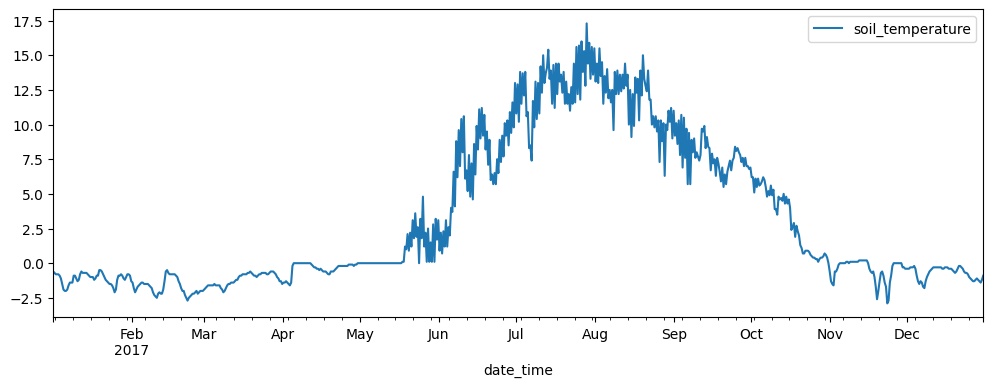

(728, 3)


In [111]:
# We really only need the 6pm and 18pm reading
ismn_passing = ismn_timeseries.data[(ismn_timeseries.data.index.hour == 6 )|(ismn_timeseries.data.index.hour == 18)]
ismn_passing.plot(figsize=(12,4))
plt.show()
print(ismn_passing.shape)


---
Since all observations are at most, daily, lets add a rolling window of 24h to each of the timeseries before we compare them


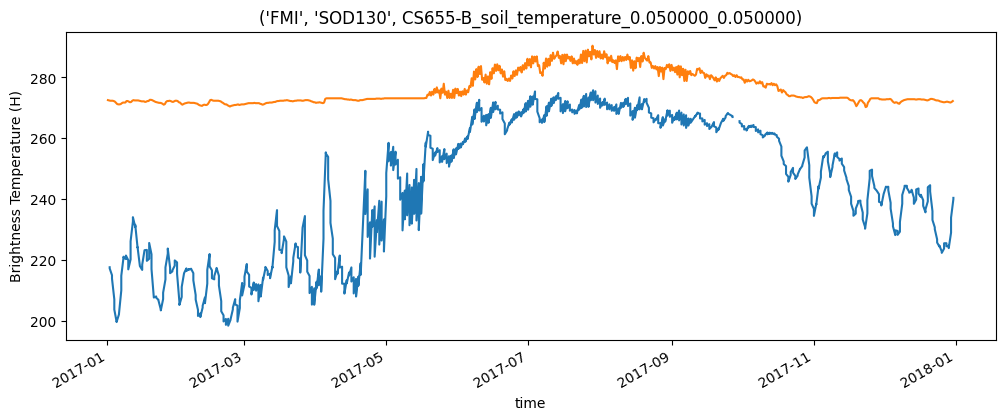

In [137]:
ka_rollingts = ka_timeseries['Brightness Temperature (H)'].rolling(time = 3).mean()
ka_rollingts.plot(figsize = (12,4))
plt.plot(ismn_passing["soil_temperature"] + 273.15) # We need to convert °C into K
message = ismn_timeseries.metadata["network"][1], ismn_timeseries.metadata["station"][1], ismn_timeseries
plt.title(message)
plt.show()


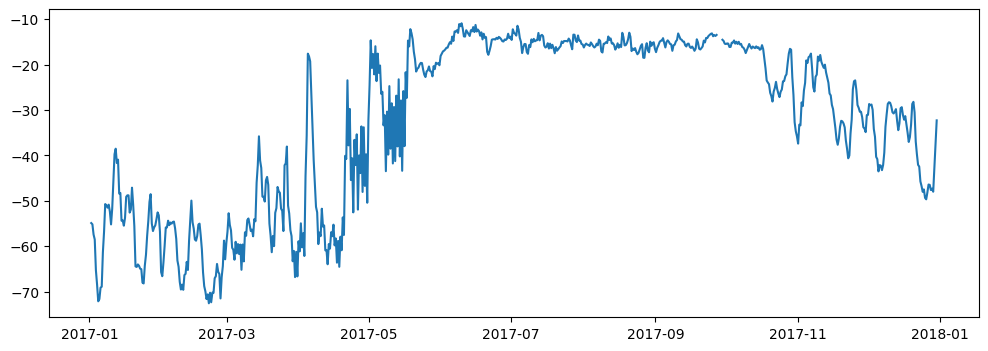

In [144]:
# Correlation coefficient
plt.figure(figsize=(12,4))
plt.plot(ka_rollingts.values[1:-1] - (ismn_passing["soil_temperature"] + 273.15))


array([      nan,       nan, 217.55666, 217.1833 , 214.93333, 213.84666,
       206.97333, 203.63   , 199.52666, 199.63   , 202.04668, 202.22664,
       209.94331, 214.75334, 221.04   , 220.78333, 220.24666, 221.41667,
       219.88   , 216.86333, 220.13335, 226.06999, 232.61665, 234.02998,
       230.76666, 231.52667, 224.05334, 224.16998, 217.96999, 217.96   ,
       216.67665, 218.40332, 223.03333, 223.16667, 223.26332, 219.66333,
       220.33665, 225.55   , 221.81   , 216.97667, 207.91998, 207.59666,
       207.94666, 207.56   , 206.81331, 206.60333, 203.62334, 203.36333,
       207.09001, 209.18999, 213.55666, 217.52666, 222.00665, 223.71666,
       217.36665, 215.59999, 216.2    , 216.55666, 218.09332, 219.80666,
       219.14998, 215.44666, 206.16667, 205.15334, 207.79333, 211.08   ,
       215.39333, 215.59001, 217.18333, 216.29665, 216.96667, 216.72667,
       216.99333, 217.08667, 215.60333, 213.26   , 208.40999, 206.93333,
       203.50667, 201.52   , 202.40334, 201.15999, 